# Importing Required Libraries

In [1]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing

Importing the Dataset

In [2]:
data = pd.read_csv('Champagne.csv')
data.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


Creating a date range

In [3]:
dates = pd.date_range(start='1964-01-01', freq='MS', periods=len(data))
dates[0:5]

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [4]:
data.set_index(dates,inplace=True)
data.drop('Month',axis=1,inplace=True)

# Forecasting  Champagne Sales for an Year ahead

## Using the Best Fit Holt Winter Model

In [5]:
train_len = int(np.ceil(len(data) * 0.75))
train=data[0:train_len] 
test=data[train_len:]

In [6]:
fit1 = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add').fit()
fit1.params

{'smoothing_level': 0.05574986291458101,
 'smoothing_slope': 1.443911683751581e-12,
 'smoothing_seasonal': 0.9053845872345992,
 'damping_slope': nan,
 'initial_level': 3339.9105862162864,
 'initial_slope': 22.2445016461074,
 'initial_seasons': array([ -630.65411606,  -773.57658123,  -687.91626227,  -723.9294304 ,
         -501.55137492,  -421.01244496, -1174.51840923, -1257.20818584,
         -539.11320431,   832.32560022,  2298.17467999,  3838.99033183]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [7]:
Forecasting = fit1.forecast(steps=12)

In [8]:
idx = pd.date_range(start='1972-10-01', periods=12, freq='MS')
Forecasting = pd.Series(Forecasting,index=idx)

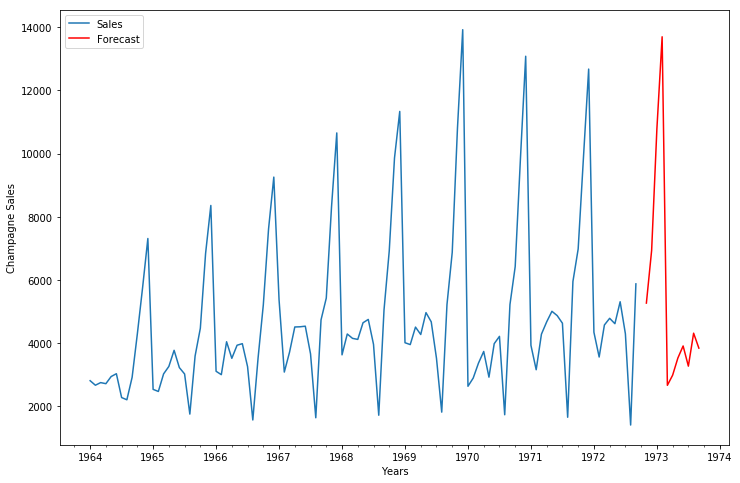

In [9]:
axis = data.plot(label='Observed', figsize=(12, 8))
Forecasting[1:].plot(ax=axis, label='Forecast',color='r')
axis.set_xlabel('Years')
axis.set_ylabel('Champagne Sales')
plt.legend(loc='upper left')
plt.show()

# Using the Best Fit SARIMA Model

In [10]:
train = (data[data.index < '1969-10-01'])
test = (data[data.index >= '1969-10-01'])

In [11]:
# using the best parameter in the model
model = SARIMAX(train,order=(0,1,1),seasonal_order=(1,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False)
model_fit = model.fit()

###  Forecasting 12 steps (1 year) ahead in future

In [12]:
n_steps = 12
# alpha=0.01 signifies 99% confidence interval
pred_uc_99 = model_fit.get_forecast(steps=12, alpha=0.01) 
# alpha=0.05 signifies 95% confidence interval
pred_uc_95 = model_fit.get_forecast(steps=12, alpha=0.05) 

Confidence interval of the forecast

In [13]:
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [14]:
pred = model_fit.get_forecast(steps=12)

In [15]:
idx = pd.date_range(start='1972-10-01', periods=n_steps, freq='MS')

In [16]:
forcasted_95ci = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean,pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

In [17]:
forcasted_99ci = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [18]:
forecast = forcasted_95ci.combine_first(forcasted_99ci)

In [19]:
forecast = forecast[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']]

In [20]:
forecast.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
1972-10-01,7052.282675,5918.428940,8186.136410,5918.428940,8186.136410
1972-11-01,9993.219228,8857.414276,11129.024179,8857.414276,11129.024179
1972-12-01,11587.670444,10449.930857,12725.410031,10449.930857,12725.410031
1973-01-01,4530.346143,3390.645614,5670.046672,3390.645614,5670.046672
1973-02-01,4261.531137,3126.657188,5396.405085,3126.657188,5396.405085


###  Plotting the forecast along with the confidence interval

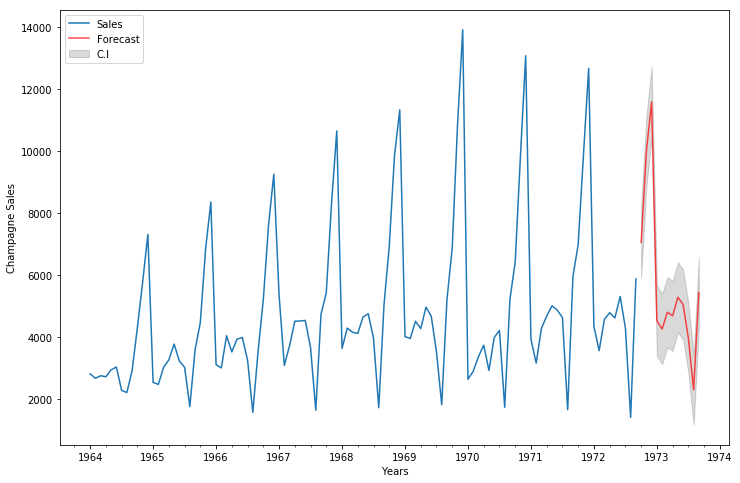

In [21]:
axis = data.plot(label='Observed', figsize=(12, 8))
forecast['forecast'].plot(ax=axis, label='Forecast',color='r',alpha=0.7)
axis.fill_between(forecast.index, forecast['lower_ci_95'], forecast['upper_ci_95'], color='k',label='C.I',alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Champagne Sales')
plt.legend(loc='upper left')
plt.show()